# The 15 min binary option

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dollar-prices-and-infos/database_15min.csv


## Introduction

This project aims to identify oportunities to enter into a 15 min binary option by predicting either if the future price of the asset, in this especific case DOL contracts, will be higher or what that price will be.
This model would be of interest to technical investors while building automated trading bots.
I will try to answer 2 questions:

- In 15 minutes the price will be higher or lower from now?
- In 15 minutes what will be the price?

It is important to notice this notebook main intent is to learn and document the entire process of data analysis and as such does not hides some hypothesis that was later discarded in the proccess. 

## Data

I will be using the "Dollar Stock Prices and infos" dataset avaiable at Kaggle.com - <https://www.kaggle.com/icarofreire/dollar-prices-and-infos>
This is the only dataset that will be used because the time window to analyse is too short and specific and it would be hard to fina any other dataset to aggregate information.
I also believe that this dataset has enough information for the prediction, even though it should be possible to aggregate other assets prices for future models.
I start by loading the dataset and naming the columns acccordingly to data creator description:

In [126]:
df = pd.read_csv('/kaggle/input/dollar-prices-and-infos/database_15min.csv', header=None, names=['time','opPrice_min_candle', 'maxPrice_min_candle', 'minPrice_min_candle', 'cloPrice_min_candle','volume', 'financial_information','negotiation', 'ma_last13', 'ma_last72', 'avg_last15_high', 
                                                                                                'avg_last15_low','diffMACD','deaMACD','MACDlh','difflh','dealh','opPrice_future15'])
df.head()

,time,opPrice_min_candle,maxPrice_min_candle,minPrice_min_candle,cloPrice_min_candle,volume,financial_information,negotiation,ma_last13,ma_last72,avg_last15_high,avg_last15_low,diffMACD,deaMACD,MACDlh,difflh,dealh,opPrice_future15
0,21-11-19 09:03,4206.0,4206.5,4204.5,4206.0,5024,211292030.0,1443,4201.6,4202.4,4202.8,4201.2,-0.637,-0.126,-0.125,-0.440,-0.377,4200.0
1,21-11-19 09:04,4206.5,4206.5,4205.0,4205.5,4451,187200190.0,1175,4202.1,4202.5,4202.9,4201.3,-0.304,-0.136,0.459,-0.090,-0.320,4201.0
2,21-11-19 09:05,4205.5,4206.5,4203.0,4204.5,6515,273933345.0,1627,4202.5,4202.5,4203.1,4201.4,-0.099,-0.134,0.679,0.105,-0.235,4199.0
3,21-11-19 09:06,4204.5,4204.5,4203.0,4203.5,2751,115640535.0,801,4202.6,4202.5,4203.1,4201.4,-0.005,-0.127,0.658,0.176,-0.153,4201.0
4,21-11-19 09:07,4203.0,4204.0,4202.0,4202.5,3360,141218695.0,1038,4202.6,4202.5,4203.1,4201.4,-0.007,-0.120,0.486,0.151,-0.092,4207.0


The columns descriptions are as follow:

- opPrice_min_candle - Opening Price of 1 Minute Candle
- maxPrice_min_candle - Maximum Price of 1 Minute Candle
- minPrice_min_candle - Minimum Price of 1 Minute Candle
- cloPrice_min_candle - Closing Price of 1 Minute Candle
- volume - Number of trades in 1 minute candle
- financial_information - volume multiplied by trade price in 1 minute candle
- negotiation - no information on this feature
- ma_last13 - price moving average in the last 13 minutes
- ma_last72 - price moving average in the last 72 minutes
- avg_last15_high - average max candle in the last 15 minutes
- avg_last15_low - average min candle in the last 15 minutes
- diffMACD - moving average convergence divergence variation
- deaMACD - no information on this feature
- MACDlh - no information on this feature
- difflh - no information on this feature
- dealh - no information on this feature
- opPrice_future15 - target - price in 15 minutes from candle

## Methodology

I started by looking at the correlation matrix of the features:

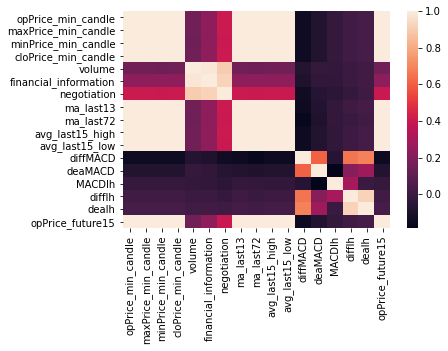

In [127]:
sns.heatmap(df.corr())

There is a lot of high correlation between features, but we should look at it with care since a lot of features in the dataset are calculations of others.
For this first analysis I will focus at the last line only, that show the correlation between features and target.
At this first look, for the linear part of the problem, we have a few strong features candidates in all the minute candle features, in the moving averages and in the avg of last 15 highs and lows.

I will take a look at the target distribution:

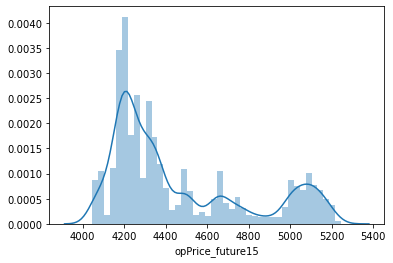

In [128]:
ax = sns.distplot(df['opPrice_future15'])

I will proceed to feature engineering.
First of all I need to create a boolean target for my first question:

In [129]:
df['target'] = df['opPrice_future15'] > df['cloPrice_min_candle']
df.head()

,time,opPrice_min_candle,maxPrice_min_candle,minPrice_min_candle,cloPrice_min_candle,volume,financial_information,negotiation,ma_last13,ma_last72,avg_last15_high,avg_last15_low,diffMACD,deaMACD,MACDlh,difflh,dealh,opPrice_future15,target
0,21-11-19 09:03,4206.0,4206.5,4204.5,4206.0,5024,211292030.0,1443,4201.6,4202.4,4202.8,4201.2,-0.637,-0.126,-0.125,-0.440,-0.377,4200.0,False
1,21-11-19 09:04,4206.5,4206.5,4205.0,4205.5,4451,187200190.0,1175,4202.1,4202.5,4202.9,4201.3,-0.304,-0.136,0.459,-0.090,-0.320,4201.0,False
2,21-11-19 09:05,4205.5,4206.5,4203.0,4204.5,6515,273933345.0,1627,4202.5,4202.5,4203.1,4201.4,-0.099,-0.134,0.679,0.105,-0.235,4199.0,False
3,21-11-19 09:06,4204.5,4204.5,4203.0,4203.5,2751,115640535.0,801,4202.6,4202.5,4203.1,4201.4,-0.005,-0.127,0.658,0.176,-0.153,4201.0,False
4,21-11-19 09:07,4203.0,4204.0,4202.0,4202.5,3360,141218695.0,1038,4202.6,4202.5,4203.1,4201.4,-0.007,-0.120,0.486,0.151,-0.092,4207.0,True


Now I begin the feature engineering.
First I'm multiplying the volume to 10 to get the real number (when we divide financial_information to volume we get the average price).
Then we get the average price, the delta price between candle opening to closing and the delta price between maximum and minimum price.
Those are all visual indicators in technical analysis.
We also get the difference between the tops and bottoms of each candle to the last one as it is another visual indicator in technical analysis.
It is important to notice here that an analysis of the last few tops and bottoms could bring more insight as to identify tendecies in the market.
I brought the MACD indicators even though some of their meaning are are not clear. We can clean those features if they are not significative in the future.

In [156]:
feat = pd.DataFrame()
#feat['neg_diffMACD'] = df['negotiation']*df['diffMACD']
feat['volume'] = df['volume']*10
feat['avg_canPrice'] = df['financial_information']/feat['volume']
feat['delta_price'] = df['cloPrice_min_candle']-df['opPrice_min_candle']
feat['maxmin'] = df['maxPrice_min_candle']-df['minPrice_min_candle']
#feat['delta_maxmin'] = feat['maxmin'].diff()
feat['movAvg13_closePrice'] = df['ma_last13'].diff()
feat['movAvg72_closePrice'] = df['ma_last72'].diff()
#feat['delta_avgtops'] = df['avg_last15_high'].diff()
#feat['delta_avgbottoms'] = df['avg_last15_low'].diff()
feat['delta_tops'] = df['maxPrice_min_candle'].diff()
feat['delta_bottoms'] = df['minPrice_min_candle'].diff()
feat[['diffMACD','deaMACD','MACDlh','difflh','dealh']] = df[['diffMACD','deaMACD','MACDlh','difflh','dealh']]
#feat[['difflh','dealh']] = df[['difflh','dealh']]
feat.fillna(0, inplace=True)
feat.head()

,volume,avg_canPrice,delta_price,maxmin,movAvg13_closePrice,movAvg72_closePrice,delta_tops,delta_bottoms,diffMACD,deaMACD,MACDlh,difflh,dealh
0,50240,4205.653463,0.0,2.0,0.0,0.0,0.0,0.0,-0.637,-0.126,-0.125,-0.440,-0.377
1,44510,4205.800719,-1.0,1.5,0.5,0.1,0.0,0.5,-0.304,-0.136,0.459,-0.090,-0.320
2,65150,4204.656101,-1.0,3.5,0.4,0.0,0.0,-2.0,-0.099,-0.134,0.679,0.105,-0.235
3,27510,4203.581788,-1.0,1.5,0.1,0.0,-2.0,0.0,-0.005,-0.127,0.658,0.176,-0.153
4,33600,4202.937351,-0.5,2.0,0.0,0.0,-0.5,-1.0,-0.007,-0.120,0.486,0.151,-0.092


Let's see how the engineered features are correlated now:

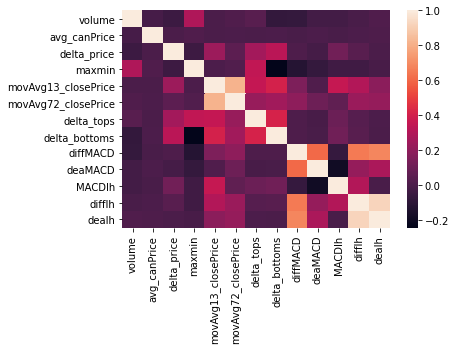

In [157]:
sns.heatmap(feat.corr())

Looking better!
I still have difflh and dealh that I have little information about and have high correlation between them so I will drop those for now.

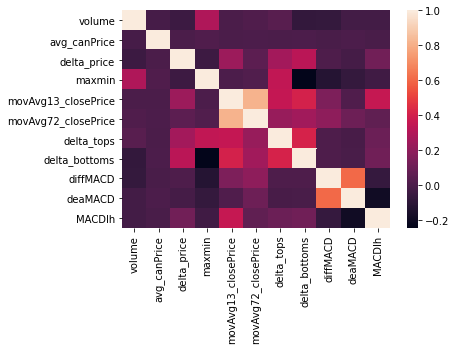

In [158]:
feat.drop(columns=['difflh','dealh'], inplace=True)
sns.heatmap(feat.corr())

Even though the moving averages have somewhat high correlation we will keep them for now and see how they fare when we test permutation importance.
Let's see how our feature set correlates to the target:

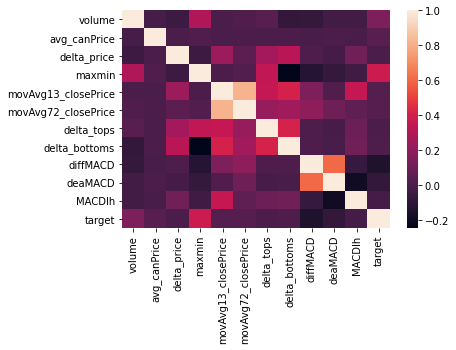

In [159]:
feat_correl = feat.copy()
feat_correl['target'] = df['opPrice_future15']
sns.heatmap(feat_correl.corr())

My transformed features, even though they don't correlate between themselves also doesnt have a high correlation index with the target, and that could be bad to our linear model.
I will also create another feature set with the high correlation original features:

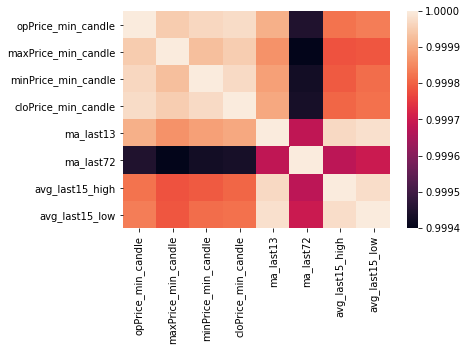

In [160]:
feat_org = df[['opPrice_min_candle','maxPrice_min_candle', 'minPrice_min_candle', 'cloPrice_min_candle','ma_last13', 'ma_last72', 'avg_last15_high', 'avg_last15_low']]
feat_correl = feat_org.copy()
feat_correl['target'] = df['opPrice_future15']


sns.heatmap(feat_org.corr())              

I will start by standarizing the features in both sets for both targets (boolean and linear):

In [182]:
from sklearn.preprocessing import StandardScaler

y_linear = df['opPrice_future15']
y_boolean = df['target']

scaler = StandardScaler()
scaler.fit(feat)
X = scaler.transform(feat)
scaler.fit(feat_org)
Xorg = scaler.transform(feat_org)

Xlin_train, Xlin_test, ylin_train, ylin_test = train_test_split(X, y_linear, random_state = 0)
Xorglin_train, Xorglin_test, yorglin_train, yorglin_test = train_test_split(Xorg, y_linear, random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_boolean, random_state = 0)
Xorg_train, Xorg_test, yorg_train, yorg_test = train_test_split(Xorg, y_boolean, random_state = 0)

## Methodology

I will start fitting both features sets(transformed and original) with some of my default parameters and models and compare scores:

In [183]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

hummerGBC = GradientBoostingClassifier(random_state=0,n_estimators=1000, n_iter_no_change=3, learning_rate=1)
hummerGBC.fit(X_train, y_train)
print('Hummer features GBC score:', hummerGBC.score(X_test, y_test))

orgGBC = GradientBoostingClassifier(random_state=0,n_estimators=1000, n_iter_no_change=3, learning_rate=1)
orgGBC.fit(Xorg_train, yorg_train)
print('Original features GBC score:', orgGBC.score(Xorg_test, yorg_test))

hummerSVC = LinearSVC(random_state=0, dual=False)
hummerSVC.fit(X_train, y_train)
print('Hummer features SVC score:', hummerSVC.score(X_test, y_test))

orgSVC = LinearSVC(random_state=0, dual=False)
orgSVC.fit(Xorg_train, yorg_train)
print('Original features SVC score:', orgSVC.score(Xorg_test, yorg_test))

hummerAda = AdaBoostClassifier(n_estimators=100, random_state=0)
hummerAda.fit(X_train,y_train)
print('Hummer features ADA score:',hummerAda.score(X_test, y_test))

orgAda = AdaBoostClassifier(n_estimators=100, random_state=0)
orgAda.fit(Xorg_train,yorg_train)
print('Original features ADA score:',orgAda.score(Xorg_test, yorg_test))

hummerLog = LogisticRegressionCV(cv=5, random_state=0)
hummerLog.fit(X_train, y_train)
print('Hummer features Log score:', hummerLog.score(X_test, y_test))

orgLog = LogisticRegressionCV(cv=5, random_state=0)
orgLog.fit(Xorg_train, yorg_train)
print('Original features Log score:', orgLog.score(Xorg_test, yorg_test))

Hummer features GBC score: 0.5714631197097945
Original features GBC score: 0.6035066505441354
Hummer features SVC score: 0.5438935912938331
Original features SVC score: 0.5081015719467956
Hummer features ADA score: 0.573639661426844
Original features ADA score: 0.5482466747279323
Hummer features Log score: 0.5430471584038694
Original features Log score: 0.5094316807738815


Our best score was with the original high correlation feature set with GBC.
Will proceed to a permutation importance analysis to see the most important features in the choosen model an also to see if we can remove some features and keep a high model score:

In [184]:
import eli5
from eli5.sklearn import PermutationImportance

Xorg_test_df = pd.DataFrame(Xorg_test, columns=feat_org.columns, index = None)
perm = PermutationImportance(orgGBC, random_state=0).fit(Xorg_test, yorg_test)
eli5.show_weights(perm, feature_names = Xorg_test_df.columns.tolist())

Weight,Feature
0.0951 ± 0.0067,ma_last72
0.0724 ± 0.0027,avg_last15_low
0.0717 ± 0.0070,avg_last15_high
0.0657 ± 0.0063,cloPrice_min_candle
0.0563 ± 0.0062,ma_last13
0.0231 ± 0.0057,maxPrice_min_candle
0.0201 ± 0.0045,minPrice_min_candle
0.0113 ± 0.0050,opPrice_min_candle


I decided to keep all features.
It is interesting to note that the most important features are:
- Moving average of last 72 mins (medium term curve)
- Average last 15 low
- Average last 15 high
- Closing candle price
- Moving average of last 13 mins (short term curve)

Let's follow on to the linear model.
As with the classification one I will run a few default models and see how they perform:

In [185]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR

hummerGBR = GradientBoostingRegressor(random_state=0)
hummerGBR.fit(Xlin_train, ylin_train)
print('Hummer feature GBR score:',hummerGBR.score(Xlin_test, ylin_test))

orgGBR = GradientBoostingRegressor(random_state=0)
orgGBR.fit(Xorglin_train, yorglin_train)
print('Original feature GBR score:',orgGBR.score(Xorglin_test, yorglin_test))

Hummer feature GBR score: 0.9966422834494431
Original feature GBR score: 0.9988809732450233


I got the best score with the original feature set.
Let's see the permutation importance:

In [186]:
Xorg_test_df = pd.DataFrame(Xorg_test, columns=feat_org.columns, index = None)
perm = PermutationImportance(orgGBR, random_state=0).fit(Xorg_test, yorg_test)
eli5.show_weights(perm, feature_names = Xorg_test_df.columns.tolist())

Weight,Feature
32153.4115 ± 2400.4805,avg_last15_high
-91014.6592 ± 1564.2222,avg_last15_low
-92236.7914 ± 3847.4366,ma_last13
-226805.9119 ± 6085.3813,opPrice_min_candle
-242431.2498 ± 11349.8044,ma_last72
-290490.3394 ± 10549.7805,maxPrice_min_candle
-415457.0244 ± 11760.9552,minPrice_min_candle
-509314.6026 ± 11397.4205,cloPrice_min_candle


Once again the main drivers are candle analysis and moving average. 
I decided to not discard any features.

## Results

### Classification problem
The classification model didn't have enough accuracy in the test set. In any feature selection made it did not perform well.
It was interesting to note that even though, from the feature set that best performed, we could identify the candle caracteristics and moving averages as the main drivers for prediction.

### Linear problem
The linear model had a very high accuracy in the test set in both feature sets selected, but the score was higher in the original feature set(with intern correlations).
It is important to note that it confirmed the drivers from the classification model, that is, candle caracteristics and moving averages.

## Discussion

By using usual technical analysis indicators we managed to predict the asset price in 15 minutes with a very high confidence but we did not manage to classify correctly ups and downs.
The classification problem is minor since we managed to predict the scalar value, and consequently the up and down outcome of the price.
The feature weight analysis showed that technical analysis indicators are indeed drivers for the future price of the target asset, even though it would be needed to verify that with other assets and with a bigger dataset.
I think some more data could enrich the model like tape reading (buying and selling orders) and future analysis should consider that.
Also, the model could use a bigger data volume. The high correlation and linear model score should no sustain in real world data for too long.

## Conclusion

Given the limited data I had I managed to see some technical analysis indicators actually helping to predict the future price of the target asset.
Even though the dataset does not seem diverse and big enough to bring the real world noise and diversity into the model. 
The almost perfect correlation scores and regression scores makes me wonder that the model would not hold toghether in a real world test for too long.
Neverthless it is a good enough starting point for more robust models with a bigger dataset and maybe more relevant data like buy and sell orders volume and prices.